Copyright 2019 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

In [ ]:
!git clone https://github.com/google-research/google-research.git

Cloning into 'google-research'...
remote: Enumerating objects: 48, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 18964 (delta 7), reused 45 (delta 4), pack-reused 18916
Receiving objects: 100% (18964/18964), 238.22 MiB | 2.03 MiB/s, done.
Resolving deltas: 100% (9075/9075), done.
Checking out files: 100% (6902/6902), done.


In [ ]:
# install tensorflow_model_optimization
!pip install tensorflow_model_optimization

In [ ]:
import sys
import os
import tarfile
import urllib
import zipfile

sys.path.append('./google-research')

# End to end example of model training and streaming/(non streaming)  inference with TF/TFlite

We will train a simple conv model on artificially generated data and run inference in non streaming and striming modes with TF/TFLite

## Imports

In [ ]:
import tensorflow as tf
import numpy as np
import tensorflow.compat.v1 as tf1
import logging
from kws_streaming.models import model_params
from kws_streaming.models import model_flags
from kws_streaming.train import test
from kws_streaming import data
tf1.disable_eager_execution()
from kws_streaming.models import models
from kws_streaming.layers import modes
from kws_streaming.layers.modes import Modes
from kws_streaming.layers import speech_features
from kws_streaming.layers.stream import Stream
from kws_streaming.models import utils

In [ ]:
config = tf1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf1.Session(config=config)

In [ ]:
# general imports
import matplotlib.pyplot as plt
import os
import json
import numpy as np
import scipy as scipy
import scipy.io.wavfile as wav
import scipy.signal

In [ ]:
tf.__version__

'2.5.0-dev20200629'

In [ ]:
tf1.reset_default_graph()
sess = tf1.Session()
tf1.keras.backend.set_session(sess)
tf1.keras.backend.set_learning_phase(0)

## Prepare artificial train data

In [ ]:
samplerate = 16000
singnal_len = samplerate # it is equalent to 1 second

label_count = 4
train_data = []
train_label = []
data_size = 1024
for b in range(data_size):
  noise = np.random.normal(size = singnal_len, scale = 0.2)
  label = np.mod(b, label_count)
  frequency = (label+1)*2
  
  signal = np.cos(2.0*np.pi*frequency*np.arange(samplerate)/samplerate) + noise
  train_data.append(signal)
  train_label.append(label)

train_data = np.array(train_data)
train_label = np.array(train_label)

label 0


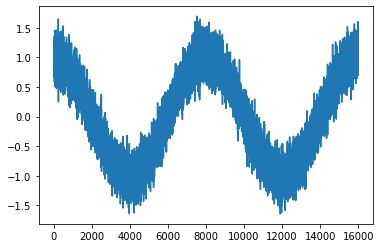

In [ ]:
ind = 0
plt.plot(train_data[ind])
print("label " + str(train_label[ind]))

## Prepare non streaming batched model

In [ ]:
FLAGS = model_params.Params()
flags = model_flags.update_flags(FLAGS)
flags.desired_samples = singnal_len
epsilon = 0.0001
batch_size = 16

In [ ]:
input_audio = tf.keras.layers.Input(shape=(singnal_len,), batch_size=batch_size)
net = input_audio
net = speech_features.SpeechFeatures(speech_features.SpeechFeatures.get_params(flags))(net)

net = tf.keras.backend.expand_dims(net)
net = Stream(cell=tf.keras.layers.Conv2D( filters=5, kernel_size=(3,3), activation='linear'))(net)
net = tf.keras.layers.BatchNormalization(epsilon=epsilon)(net)
net = tf.keras.layers.ReLU(6.)(net)
net = Stream(cell=tf.keras.layers.Flatten())(net)
net = tf.keras.layers.Dense(units=label_count)(net)
model_non_stream_batch = tf.keras.Model(input_audio, net)

In [ ]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(epsilon=flags.optimizer_epsilon)
model_non_stream_batch.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

## Train non streaming batched model

In [ ]:
# we just overfit the model on artificial data
for i in range(data_size//batch_size):
  ind = i * batch_size
  train_data_batch = train_data[ind:ind+batch_size,]
  train_label_batch = train_label[ind:ind+batch_size,]
  result = model_non_stream_batch.train_on_batch(train_data_batch, train_label_batch)
  if not (i % 5):
    print("accuracy on training batch " + str(result[1] * 100))

accuracy on training batch 18.75
accuracy on training batch 25.0
accuracy on training batch 25.0
accuracy on training batch 31.25
accuracy on training batch 50.0
accuracy on training batch 62.5
accuracy on training batch 68.75
accuracy on training batch 87.5
accuracy on training batch 87.5
accuracy on training batch 75.0
accuracy on training batch 81.25
accuracy on training batch 87.5
accuracy on training batch 87.5


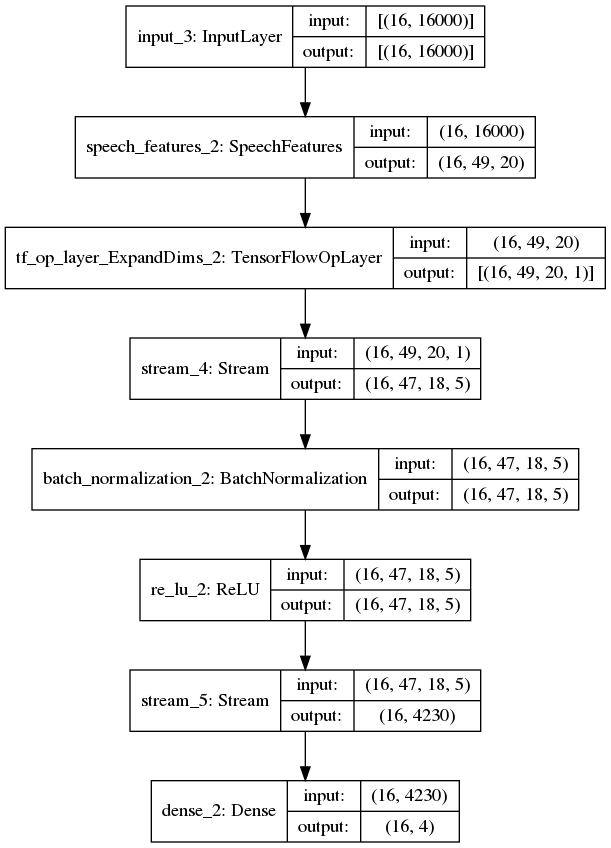

In [ ]:
tf.keras.utils.plot_model(
    model_non_stream_batch,
    show_shapes=True,
    show_layer_names=True,
    expand_nested=True)

## Run inference with TF

### TF Run non streaming inference

In [ ]:
# convert model to inference mode with batch one
inference_batch_size = 1
tf.keras.backend.set_learning_phase(0)
flags.batch_size = inference_batch_size  # set batch size

model_non_stream = utils.to_streaming_inference(model_non_stream_batch, flags, Modes.NON_STREAM_INFERENCE)
#model_non_stream.summary()

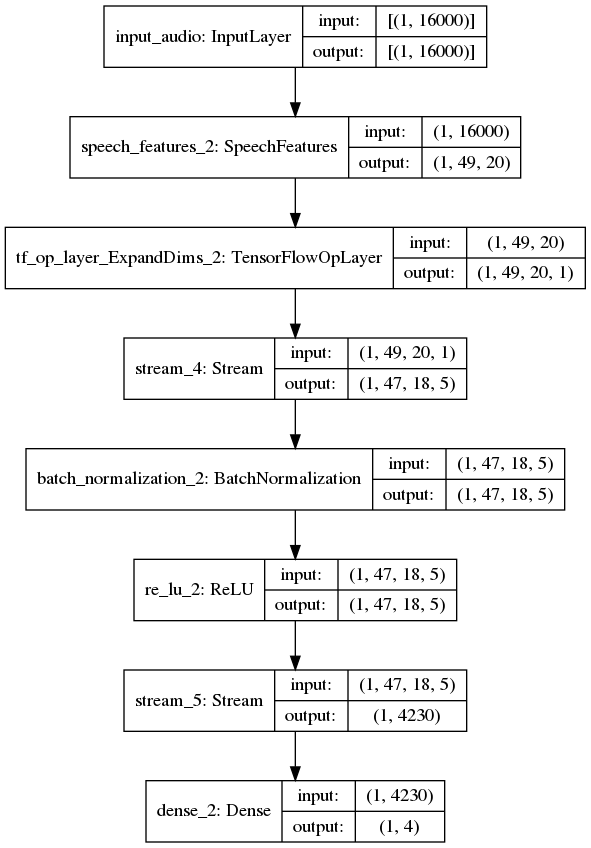

In [ ]:
tf.keras.utils.plot_model(
    model_non_stream,
    show_shapes=True,
    show_layer_names=True,
    expand_nested=True)

In [ ]:
predictions = model_non_stream.predict(train_data)
predicted_labels = np.argmax(predictions, axis=1)

In [ ]:
predicted_labels

array([0, 1, 2, ..., 1, 2, 3])

In [ ]:
accuracy = np.sum(predicted_labels==train_label)/len(train_label)
print("accuracy " + str(accuracy * 100))

accuracy 93.5546875


### TF Run streaming inference with internal state

In [ ]:
# convert model to streaming mode
flags.batch_size = inference_batch_size  # set batch size

model_stream = utils.to_streaming_inference(model_non_stream_batch, flags, Modes.STREAM_INTERNAL_STATE_INFERENCE)
#model_stream.summary()

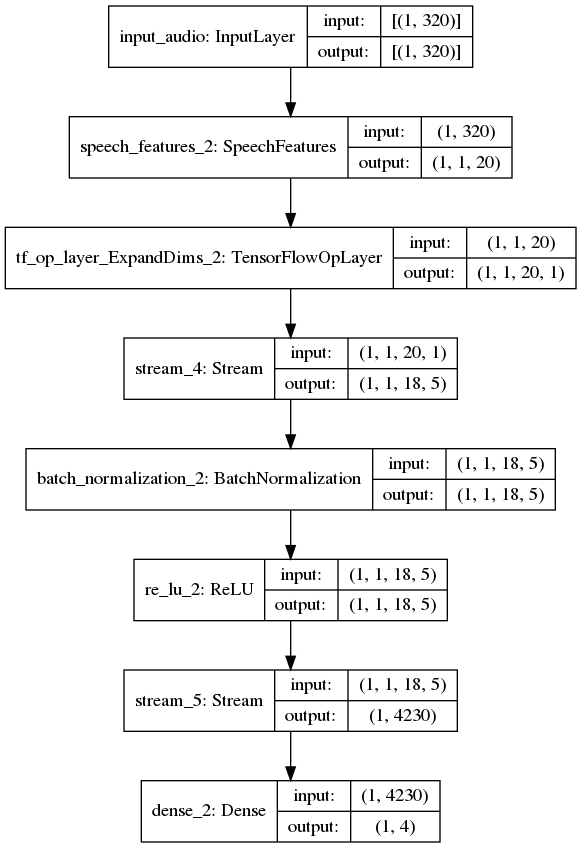

In [ ]:
tf.keras.utils.plot_model(
    model_stream,
    show_shapes=True,
    show_layer_names=True,
    expand_nested=True)

In [ ]:

sream_predicted_labels = []
for input_data in train_data: # loop over all audio sequences
  
  # add batch dim - it is always 1 for streaming inference mode
  input_data = np.expand_dims(input_data, axis=0)

  #   output_predictions = []
  #   output_ids = []
  # run streaming inference on one audio sequence
  start = 0
  end = flags.window_stride_samples
  while end <= input_data.shape[1]: # loop over one audio sequence sample by sample
    stream_update = input_data[:, start:end]

    # get new frame from stream of data
    stream_output_prediction = model_stream.predict(stream_update)
    stream_output_arg = np.argmax(stream_output_prediction)
    #     output_predictions.append(stream_output_prediction[0][stream_output_arg])
    #     output_ids.append(stream_output_arg)

    # update indexes of streamed updates
    start = end
    end = start + flags.window_stride_samples

  sream_predicted_labels.append(stream_output_arg)

In [ ]:
# validate that accuracy in streaming mode is the same with accuracy in non streaming mode
stream_accuracy_internal_state = np.sum(sream_predicted_labels==train_label)/len(train_label)
print("accuracy " + str(stream_accuracy_internal_state * 100))

accuracy 93.5546875


### TF Run streaming inference with external state

In [ ]:
# convert model to streaming mode
flags.batch_size = inference_batch_size  # set batch size

model_stream = utils.to_streaming_inference(model_non_stream_batch, flags, Modes.STREAM_EXTERNAL_STATE_INFERENCE)
#model_stream.summary()

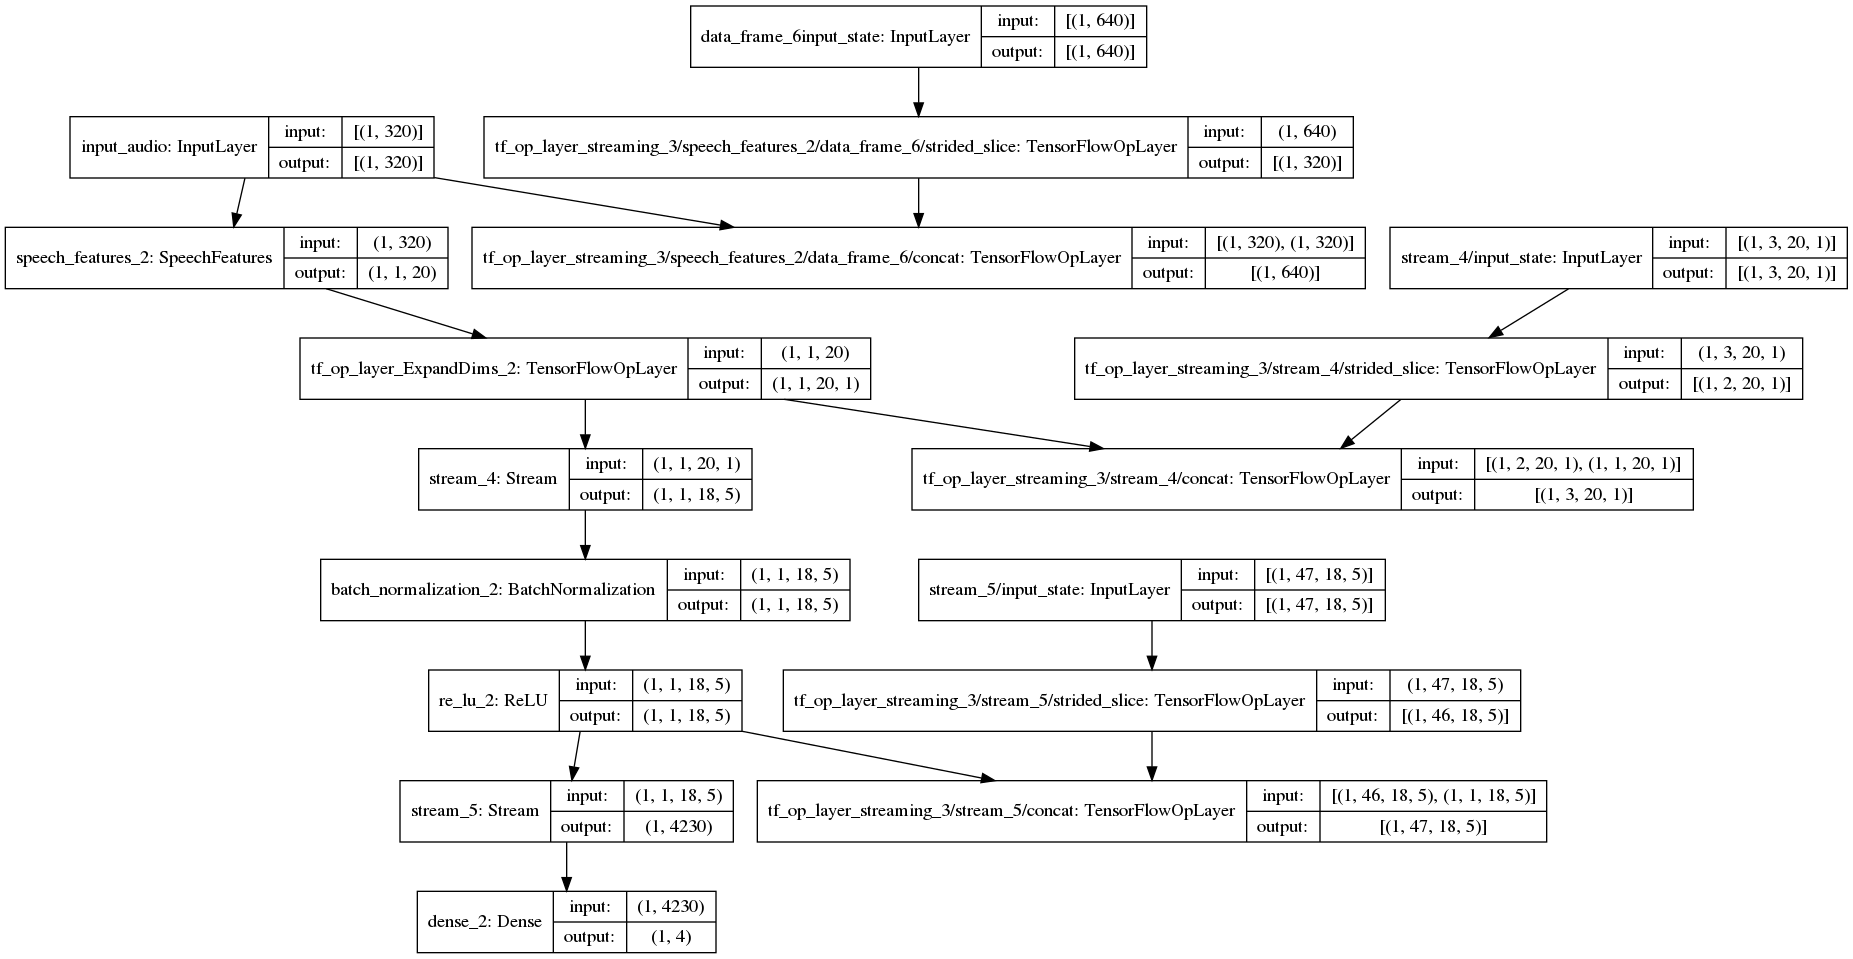

In [ ]:
tf.keras.utils.plot_model(
    model_stream,
    show_shapes=True,
    show_layer_names=True,
    expand_nested=True)

In [ ]:
sream_external_state_predicted_labels = []
for input_data in train_data: # loop over all audio sequences
  
  # add batch dim - it is always 1 for streaming inference mode
  input_data = np.expand_dims(input_data, axis=0)
  
  # output_predictions = []
  # output_ids = []
  inputs = []
  for s in range(len(model_stream.inputs)):
    inputs.append(np.zeros(model_stream.inputs[s].shape, dtype=np.float32))

  reset_state = True

  if reset_state:
    for s in range(len(model_stream.inputs)):
      inputs[s] = np.zeros(model_stream.inputs[s].shape, dtype=np.float32)

  start = 0
  end = flags.window_stride_samples
  while end <= input_data.shape[1]:
    # get new frame from stream of data
    stream_update = input_data[:, start:end]

    # update indexes of streamed updates
    start = end
    end = start + flags.window_stride_samples

    # set input audio data (by default input data at index 0)
    inputs[0] = stream_update

    # run inference
    outputs = model_stream.predict(inputs)

    # get output states and set it back to input states
    # which will be fed in the next inference cycle
    for s in range(1, len(model_stream.inputs)):
      inputs[s] = outputs[s]

    stream_output_arg = np.argmax(outputs[0])

    # output_predictions.append(outputs[0][0][stream_output_arg])
    # output_ids.append(stream_output_arg)  
    
  sream_external_state_predicted_labels.append(stream_output_arg)

In [ ]:
# validate that accuracy in streaming mode with external states is the same with accuracy in non streaming mode
stream_accuracy_external_state = np.sum(sream_external_state_predicted_labels==train_label)/len(train_label)
print("accuracy " + str(stream_accuracy_external_state * 100))

accuracy 93.5546875


## Run inference with TFlite

### Run non streaming inference with TFLite

In [ ]:
# path = os.path.join(train_dir, 'tflite_non_stream')
# tflite_model_name = 'non_stream.tflite'

tflite_non_streaming_model = utils.model_to_tflite(sess, model_non_stream, flags, Modes.NON_STREAM_INFERENCE)

In [ ]:
# prepare TFLite interpreter
# with tf.io.gfile.Open(os.path.join(path, tflite_model_name), 'rb') as f:
#   model_content = f.read()

interpreter = tf.lite.Interpreter(model_content=tflite_non_streaming_model)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

inputs = []
for s in range(len(input_details)):
  inputs.append(np.zeros(input_details[s]['shape'], dtype=np.float32))

In [ ]:
padded_input = np.zeros((1, 16000), dtype=np.float32)
padded_input[:, :input_data.shape[1]] = input_data

In [ ]:
non_sream_tflite_predicted_labels = []
for input_data in train_data: # loop over all audio sequences
  
  # add batch dim - it is always 1 for streaming inference mode
  input_data = np.expand_dims(input_data, axis=0)
  
  # set input audio data (by default input data at index 0)
  interpreter.set_tensor(input_details[0]['index'], input_data.astype(np.float32))

  # run inference
  interpreter.invoke()

  # get output: classification
  out_tflite = interpreter.get_tensor(output_details[0]['index'])

  out_tflite_argmax = np.argmax(out_tflite)

  non_sream_tflite_predicted_labels.append(out_tflite_argmax)

In [ ]:
# validate that accuracy in TFLite is the same with TF
non_stream_accuracy_tflite = np.sum(non_sream_tflite_predicted_labels==train_label)/len(train_label)
print("accuracy " + str(non_stream_accuracy_tflite * 100))


accuracy 93.5546875


### Run streaming inference with TFLite

In [ ]:
# path = os.path.join(train_dir, 'tflite_stream_state_external')
# tflite_model_name = 'stream_state_external.tflite'

tflite_streaming_model = utils.model_to_tflite(sess, model_non_stream, flags, Modes.STREAM_EXTERNAL_STATE_INFERENCE)

In [ ]:
# with tf.io.gfile.Open(os.path.join(path, tflite_model_name), 'rb') as f:
#   model_content = f.read()

interpreter = tf.lite.Interpreter(model_content=tflite_streaming_model)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

inputs = []
for s in range(len(input_details)):
  inputs.append(np.zeros(input_details[s]['shape'], dtype=np.float32))

In [ ]:
input_details[0]['shape']

array([  1, 320], dtype=int32)

In [ ]:
sream_external_state_tflite_predicted_labels = []
for input_data in train_data: # loop over all audio sequences
  
  # add batch dim - it is always 1 for streaming inference mode
  input_data = np.expand_dims(input_data, axis=0)
  
  reset_state = True

  # before processing new test sequence we can reset model state
  # if we reset model state then it is not real streaming mode
  if reset_state:
    for s in range(len(input_details)):
#       print(input_details[s]['shape'])
      inputs[s] = np.zeros(input_details[s]['shape'], dtype=np.float32)

  start = 0
  end = flags.window_stride_samples
  while end <= input_data.shape[1]:
    stream_update = input_data[:, start:end]
    stream_update = stream_update.astype(np.float32)

    # update indexes of streamed updates
    start = end
    end = start + flags.window_stride_samples

    # set input audio data (by default input data at index 0)
    interpreter.set_tensor(input_details[0]['index'], stream_update)

    # set input states (index 1...)
    for s in range(1, len(input_details)):
      interpreter.set_tensor(input_details[s]['index'], inputs[s])

    # run inference
    interpreter.invoke()

    # get output: classification
    out_tflite = interpreter.get_tensor(output_details[0]['index'])
    #print(start / 16000.0, np.argmax(out_tflite), np.max(out_tflite))

    # get output states and set it back to input states
    # which will be fed in the next inference cycle
    for s in range(1, len(input_details)):
      # The function `get_tensor()` returns a copy of the tensor data.
      # Use `tensor()` in order to get a pointer to the tensor.
      inputs[s] = interpreter.get_tensor(output_details[s]['index'])

    out_tflite_argmax = np.argmax(out_tflite)
  sream_external_state_tflite_predicted_labels.append(out_tflite_argmax)

In [ ]:
# validate that accuracy in streaming mode with external states is the same with accuracy in non streaming mode
stream_accuracy_tflite = np.sum(sream_external_state_tflite_predicted_labels==train_label)/len(train_label)
print("accuracy " + str(stream_accuracy_tflite * 100))


accuracy 93.5546875
